In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import scipy
import scipy.io
from scipy.signal import spectrogram
import os
import soundfile as sf
import librosa
import math
from librosa.feature import melspectrogram
from librosa.display import specshow
import cv2
import random
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report

In [2]:
# Try with 1D convolution

# Get dataset
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8k.csv')

class_dict = {'siren': 0,
             'jackhammer': 1,
             'air_conditioner': 2,
             'drilling': 3,
             'children_playing': 4,
             'street_music': 5,
             'dog_bark': 6,
             'engine_idling': 7,
             'gun_shot': 8,
             'car_horn': 9}

class SoundDataset(Dataset):
    def __init__(self, metadata):
        self.sample_list = []
        
        for i in range(1,11):
            data_dir = 'fold{}'.format(i)
            if (data_dir[0] == '.'):
                continue
        
            for filename in os.listdir('UrbanSound8k/audio/{}'.format(data_dir)):
                if filename[0] == '.':
                    continue
                data, samplerate = librosa.load('UrbanSound8k/audio/{}/{}'.format(data_dir,filename))
                label = metadata.loc[metadata['slice_file_name'] == filename, 'class'].item()
                if len(data.shape) == 2:
                    data = np.mean(data, axis = 1)
                if len(data) == 88200 and label != 'gun_shot' and label != 'car_horn':
                    self.sample_list.append((class_dict[label], torch.tensor(data),
                                             samplerate, i, filename)) #class label, data, samplerate, fold, filename
                if len(data) == 88200 and label == 'car_horn':
                    self.sample_list.append((8, torch.tensor(data),
                                             samplerate, i, filename)) #class label, data, samplerate, fold, filename
                
    
    def __len__(self):
        return len(self.sample_list)
    
    def __getitem__(self, idx):
        return self.sample_list[idx]

In [3]:
# Load the data (audio)
dataset = SoundDataset(metadata)

In [9]:
# Split into train, val, test data
train_len = int(0.6 * len(dataset))
val_len = len(dataset) - train_len
trainset, valset = random_split(dataset, [train_len, val_len])

val_len = int(0.5 * len(valset))
valset, testset = random_split(valset, [val_len, val_len])

In [10]:
# Empty all dataset dirs
for root, dirs, files in os.walk('Datasets'):
    for f in files:
        os.remove(os.path.join(root, f))

In [11]:
# Save the raw data into its Raw Data Folder
for label, data, samplerate, fold, filename in trainset:
    save_str = f'class{label}-fold{fold}-{filename}'
    sf.write(file=f'Datasets/train/Raw/{save_str}', data=data, samplerate=samplerate)

for label, data, samplerate, fold, filename in valset:
    save_str = f'class{label}-fold{fold}-{filename}'
    sf.write(file=f'Datasets/val/Raw/{save_str}', data=data, samplerate=samplerate)

for label, data, samplerate, fold, filename in testset:
    save_str = f'class{label}-fold{fold}-{filename}'
    sf.write(file=f'Datasets/test/Raw/{save_str}', data=data, samplerate=samplerate)

In [12]:
# Create spectrograms in the Spectrograms directories
for label, data, samplerate, fold, filename in trainset:
    save_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Spectrogram.png'
    spect = melspectrogram(data.numpy(), samplerate)
    plt.imsave(f'Datasets/train/Spectrograms/{save_str}', spect, cmap='gray')
    
    
for label, data, samplerate, fold, filename in valset:
    save_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Spectrogram.png'
    spect = melspectrogram(data.numpy(), samplerate)
    plt.imsave(f'Datasets/val/Spectrograms/{save_str}', spect, cmap='gray')
    
    
for label, data, samplerate, fold, filename in testset:
    save_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Spectrogram.png'
    spect = melspectrogram(data.numpy(), samplerate)
    plt.imsave(f'Datasets/test/Spectrograms/{save_str}', spect, cmap='gray')

In [13]:
# Add Gaussian noise to the raw data and save raw data and spectrograms
def get_white_noise(signal, snr):
    rms_sig = math.sqrt(np.mean(signal**2))
    rms_n = math.sqrt(rms_sig**2 / (pow(10, snr / 10)))
    noise = np.random.normal(0, rms_n, len(signal))
    
    return noise

for label, data, samplerate, fold, filename in trainset:
    raw_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Noisy-Raw.wav'
    spect_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Noisy-Raw-Spectrogram.png'
    signal = data.numpy()
    noisy_signal = signal + get_white_noise(signal, 1)
    noisy_spect = melspectrogram(noisy_signal, samplerate)
    
    sf.write(file=f'Datasets/train/NoisyRaw/{raw_str}', data=noisy_signal, samplerate=samplerate)  # save noisy raw
    plt.imsave(f'Datasets/train/NoisyRawSpectrograms/{spect_str}', noisy_spect, cmap='gray')  # save noisy spectrogram
    
    # now add noise to the spectrogram itself directly and save the result
    spect_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Noisy-Spectrogram.png'
    spect = melspectrogram(signal, samplerate)
    noisy_spect = np.reshape(spect.ravel() + get_white_noise(spect.ravel(), 5), (128,173))
    plt.imsave(f'Datasets/train/NoisySpectrograms/{spect_str}', noisy_spect, cmap='gray')  # save noisy spectrogram
    
for label, data, samplerate, fold, filename in valset:
    raw_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Noisy-Raw.wav'
    spect_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Noisy-Raw-Spectrogram.png'
    signal = data.numpy()
    noisy_signal = signal + get_white_noise(signal, 1)
    noisy_spect = melspectrogram(noisy_signal, samplerate)
    
    sf.write(file=f'Datasets/val/NoisyRaw/{raw_str}', data=noisy_signal, samplerate=samplerate)  # save noisy raw
    plt.imsave(f'Datasets/val/NoisyRawSpectrograms/{spect_str}', noisy_spect, cmap='gray')  # save noisy spectrogram
    
    # now add noise to the spectrogram itself directly and save the result
    spect_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Noisy-Spectrogram.png'
    spect = melspectrogram(signal, samplerate)
    noisy_spect = np.reshape(spect.ravel() + get_white_noise(spect.ravel(), 5), (128,173))
    plt.imsave(f'Datasets/val/NoisySpectrograms/{spect_str}', noisy_spect, cmap='gray')  # save noisy spectrogram
    
    
for label, data, samplerate, fold, filename in testset:
    raw_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Noisy-Raw.wav'
    spect_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Noisy-Raw-Spectrogram.png'
    signal = data.numpy()
    noisy_signal = signal + get_white_noise(signal, 1)
    noisy_spect = melspectrogram(noisy_signal, samplerate)
    
    sf.write(file=f'Datasets/test/NoisyRaw/{raw_str}', data=noisy_signal, samplerate=samplerate)  # save noisy raw
    plt.imsave(f'Datasets/test/NoisyRawSpectrograms/{spect_str}', noisy_spect, cmap='gray')  # save noisy spectrogram
    
    # now add noise to the spectrogram itself directly and save the result
    spect_str = f'class{label}-fold{fold}-{filename}'.split('.')[0] + '-Noisy-Spectrogram.png'
    spect = melspectrogram(signal, samplerate)
    noisy_spect = np.reshape(spect.ravel() + get_white_noise(spect.ravel(), 5), (128,173))
    plt.imsave(f'Datasets/test/NoisySpectrograms/{spect_str}', noisy_spect, cmap='gray')  # save noisy spectrogram

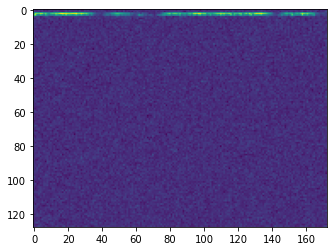

In [14]:
plt.imshow(noisy_spect)